In [21]:
#!pip install <package>

In [22]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import pyransac3d as pyrsc

# https://betterprogramming.pub/point-cloud-computing-from-rgb-d-images-918414d57e80#3de9
# Read depth image:

depth_image = imageio.v2.imread('Depth-Gray.png')
# depth_image = np.load('depth.png')
rgb_image = imageio.v2.imread('Color.jpeg')

# print properties:
print(f"Image resolution: {depth_image.shape}")
print(f"Data type: {depth_image.dtype}")
print(f"Min value: {np.min(depth_image)}")
print(f"Max value: {np.max(depth_image)}")

Image resolution: (540, 960)
Data type: uint16
Min value: 0
Max value: 11978


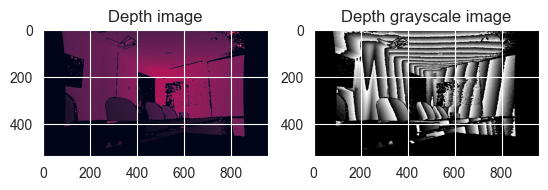

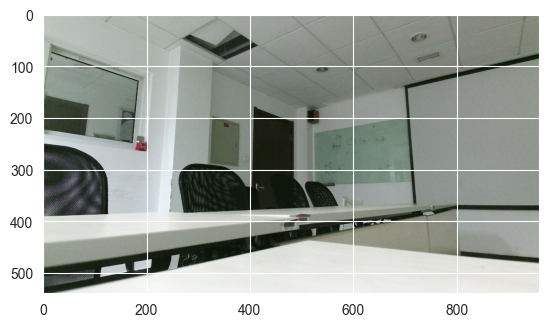

In [23]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(depth_image)
axs[0].set_title('Depth image')
axs[1].imshow(np.array(256 * depth_image / 0x0fff,dtype=np.uint8), cmap="gray")
axs[1].set_title('Depth grayscale image')
plt.show()

plt.imshow(rgb_image)
plt.show()

In [24]:
# Depth camera calibration
FX_DEPTH = 211.348495
FY_DEPTH = 211.348495
CX_DEPTH = 212.030106
CY_DEPTH = 117.634529

height = depth_image.shape[0]
width = depth_image.shape[1]

In [25]:
# Compute the grayscale image:
depth_grayscale = np.array(256 * depth_image / 0x0fff, dtype=np.uint8)
# Convert a grayscale image to a 3-channel image:
depth_grayscale = np.stack((depth_grayscale,) * 3, axis=-1)

# compute indices and reshape it to have the same shape as the depth image:
jj = np.tile(range(width), height).reshape((height, width))
ii = np.repeat(range(height), width).reshape((height, width))
# Compute constants:
xx = (jj - CX_DEPTH) / FX_DEPTH
yy = (ii - CY_DEPTH) / FY_DEPTH
# compute organised point cloud:
organized_pcd = np.dstack((xx * depth_image, yy * depth_image, depth_image))

# Ground_detection:
THRESHOLD = 1365  # Define a threshold
y_max = max(organized_pcd.reshape((height * width, 3)), key=lambda x: x[1])[1]  # Get the max value

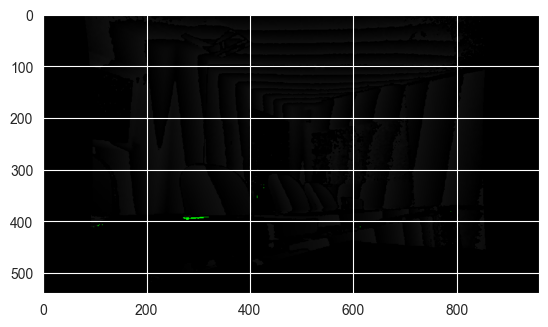

In [26]:
# Set the ground pixels to green and compute filtered point cloud:
pcd = []
for i in range(height):
    for j in range(width):
        if organized_pcd[i][j][1] >= y_max - THRESHOLD:
            depth_grayscale[i][j] = [0, 255, 0]  # Update the depth image

        # let's filter by the depth
        elif (organized_pcd[i][j][2] >= 282) & (organized_pcd[i][j][2] <= 300):
            # Mark the object
            depth_grayscale[i][j] = [150, 15, 15] 

            # Add coordinates to point cloud
            z = depth_image[i][j]
            x = (j - CX_DEPTH) * z / FX_DEPTH
            y = (i - CY_DEPTH) * z / FY_DEPTH
            pcd.append([x, y, z])
            
# Display depth_grayscale:
plt.imshow(depth_grayscale)
plt.show()

In [ ]:
pcd_clear3 = o3d.geometry.PointCloud()  # create point cloud object
pcd_clear3.points = o3d.utility.Vector3dVector(pcd)  # set pcd_np as the point cloud points
# Visualize:
o3d.visualization.draw_geometries([pcd_clear3])

In [ ]:
# RANSAC Model Fitting
np_pcd = np.array(pcd)
plane1 = pyrsc.Plane()
best_eq, best_inliers = plane1.fit(np_pcd, 282)

# https://miro.medium.com/max/1400/1*66oSaqgHSz33NVsVikwGPg.png
print(f'Plane eqution: {best_eq[0]}x + {best_eq[1]}y + {best_eq[2]}z + {best_eq[3]} = 0')

print('So the distance from the origin to the object is about ' +
      f'{best_eq[3]/np.sqrt(best_eq[0] ** 2 + best_eq[1] ** 2 + best_eq[2] ** 2)} mm')